In [27]:
from __future__ import division
from importlib import reload
from modules import * 

import csv
import pickle
fig_savedir = '../data/figures/'

In [28]:
grid_params = {
    'y_height':     20, 
    'x_width':      20,
    'walls':        False,
    'rho':          0,
    'maze_type':    'none',
    'port_shift':   'none' 
}

#make environment
maze = eu.gridworld(grid_params)

(14, 14)


In [3]:
def reset_agt(agent_params):
        ## some stupid reward placement shit -- replace later
    if agent_params['load_model'] == True:
        if agent_params['rwd_placement'] == 'training_loc':
            maze.set_rwd([(int(grid_params['y_height']/2),int(grid_params['x_width']/2))])
        if agent_params['rwd_placement'] == 'moved_loc':
            maze.set_rwd([(int(grid_params['y_height']/4),int(3*grid_params['x_width']/4))])
    else:
        maze.set_rwd([(int(grid_params['y_height']/2),int(grid_params['x_width']/2))])

    # make agent 
    agent_params = sg.gen_input(maze, agent_params)
    MF,opt = ac.make_agent(agent_params, freeze=False)

    if agent_params['use_EC']:
        #agent_params['cachelim'] = int(0.5*np.prod(maze.grid.shape))
        agent_params['EC'] = ec.ep_mem(MF,agent_params['cachelim'])

    run_dict = {
        'NUM_EVENTS':   300,
        'NUM_TRIALS':   2000,
        'environment':  maze,
        'agent':        MF,
        'optimizer':    opt,
        'agt_param':    agent_params
    }
    
    return run_dict

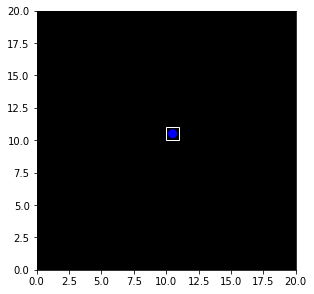

In [11]:
agent_params = {
        'load_model':   True,
        'load_dir':     '../data/outputs/gridworld/open_field{}{}.pt'.format(grid_params['x_width'],grid_params['y_height']),
        'rwd_placement':'training_loc',
        'action_dims':  len(maze.actionlist),
        'lin_dims':     500,
        'batch_size':   1,
        'gamma':        0.98, #discount factor
        'eta':          5e-4,
        'temperature':  1,
        'use_EC':       False,
        'cachelim':     100, # memory limit should be ~75% of #actions x #states
        'state_type':   'conv'
    }

run_dict = reset_agt(agent_params)
gp.plot_env(maze)

In [12]:
reset_agt(agent_params)
reload(expt)
#expt.run_full_trials(run_dict, pen = 0)
expt.run_truncated_trials(run_dict, pen=-0.01, use_EC=False)

[15:17:27]  Trial 1 TotRew = 0.94 (0.033s)
[15:17:56]  Trial 101 TotRew = -2.99999999999998 (28.716s)
[15:18:31]  Trial 201 TotRew = 0.7699999999999999 (35.169s)
[15:18:39]  Trial 301 TotRew = 0.6299999999999999 (7.770s)
[15:18:44]  Trial 401 TotRew = 0.82 (5.139s)
[15:18:48]  Trial 501 TotRew = 0.99 (4.045s)
[15:18:53]  Trial 601 TotRew = 0.97 (4.713s)
[15:18:56]  Trial 701 TotRew = 0.96 (3.585s)
[15:19:00]  Trial 801 TotRew = 0.91 (3.443s)
[15:19:03]  Trial 901 TotRew = 0.9299999999999999 (3.539s)
[15:19:06]  Trial 1001 TotRew = 0.94 (2.974s)
[15:19:09]  Trial 1101 TotRew = 0.94 (3.113s)
[15:19:13]  Trial 1201 TotRew = 0.95 (3.199s)
[15:19:16]  Trial 1301 TotRew = 0.98 (2.957s)
[15:19:19]  Trial 1401 TotRew = 0.91 (3.188s)
[15:19:22]  Trial 1501 TotRew = 0.96 (3.015s)
[15:19:25]  Trial 1601 TotRew = 0.97 (3.057s)
[15:19:28]  Trial 1701 TotRew = 0.87 (3.030s)
[15:19:31]  Trial 1801 TotRew = 0.96 (3.065s)
[15:19:34]  Trial 1901 TotRew = 0.7799999999999999 (3.206s)
[15:19:37]  Trial 200

In [13]:
second_train_loss = run_dict['total_loss']

In [29]:
policy_loss = first_train_loss[0] + second_train_loss[0]
value_loss = first_train_loss[1] + second_train_loss[1]

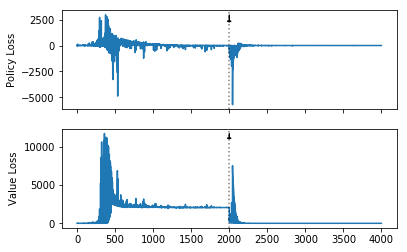

In [70]:
fig,ax = plt.subplots(2,1, sharex=True)
ax[0].plot(policy_loss)
ax[0].axvline(x = run_dict['NUM_TRIALS'],color='k', linestyle=':', alpha=0.5)
ax[0].set_ylabel('Policy Loss')
ax[1].plot(value_loss)
ax[1].axvline(x = run_dict['NUM_TRIALS'],color='k', linestyle=':', alpha=0.5)
ax[1].set_ylabel('Value Loss')

ax[0].arrow(2000, max(policy_loss), 0, -600, head_width=50, head_length=100, fc='k', ec='k')
ax[1].arrow(2000, max(value_loss), 0, -600, head_width=50, head_length=100, fc='k', ec='k')

plt.savefig('../data/figures/loss_after_trunc_training.svg', format='svg')
plt.show()
plt.close()

In [24]:
pick = [policy_loss, value_loss]

In [ ]:

outfile = open(pick,'wb')
pickle.dump(pick, open())

In [10]:
ac.torch.save(run_dict['agent'],agent_params['load_dir'])